<a href="https://www.kaggle.com/code/mh0386/logistic-regression-from-scratch?scriptVersionId=178808018" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [45]:
from typing import Literal
from cv2 import getRotationMatrix2D, warpAffine, flip, resize
import matplotlib.pyplot as plt
import numpy as np
from kagglehub import dataset_download
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from pathlib import Path
from collections import Counter
from matplotlib.pyplot import imread
from numpy import uint
from numpy.typing import NDArray

# Loading Data

In [46]:
path: str = dataset_download(handle="rashikrahmanpritom/covid-wwo-pneumonia-chest-xray")

covid_without_PNEUMONIA_train_path = Path(f"{path}/Data/train/covid_without_PNEUMONIA")
covid_with_PNEUMONIA_train_path = Path(f"{path}/Data/train/covid_with_PNEUMONIA")

covid_without_PNEUMONIA_test_path = Path(f"{path}/Data/test/covid_without_PNEUMONIA")
covid_with_PNEUMONIA_test_path = Path(f"{path}/Data/test/covid_with_PNEUMONIA")

In [47]:
covid_without_PNEUMONIA_path: list[Path] = [
    covid_without_PNEUMONIA_train_path,
    covid_without_PNEUMONIA_test_path,
]

covid_with_PNEUMONIA_path: list[Path] = [
    covid_with_PNEUMONIA_train_path,
    covid_with_PNEUMONIA_test_path,
]

In [48]:
np.random.seed(seed=42)
# random.seed(a=42)

In [49]:
label2category: dict[str, int] = {
    "covid_without_PNEUMONIA": 0,
    "covid_with_PNEUMONIA": 1,
}
category2label: dict[int, str] = {
    0: "covid_without_PNEUMONIA",
    1: "covid_with_PNEUMONIA",
}

In [50]:
data: list[dict[str, str]] = []

for path in covid_without_PNEUMONIA_path:
    for img in path.glob(pattern="*.jpeg"):
        data.append({"img_path": str(object=img), "label": "covid_without_PNEUMONIA"})

for path in covid_with_PNEUMONIA_path:
    for img in path.glob(pattern="*.jpeg"):
        data.append({"img_path": str(object=img), "label": "covid_with_PNEUMONIA"})

In [51]:
def counter_label(data: list[dict[str, str]], key: str) -> Counter[str]:
    return Counter([record[key] for record in data])

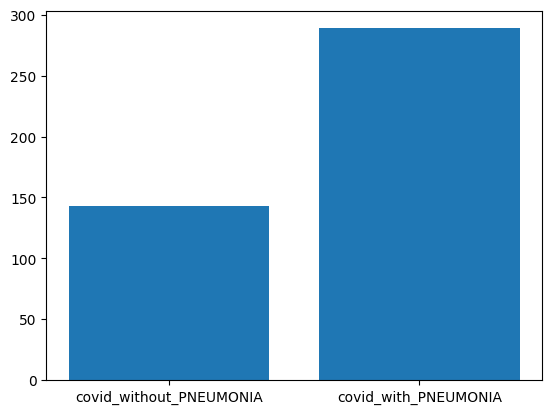

In [52]:
img_l_counter: Counter[str] = counter_label(data=data, key="label")

keys = list(img_l_counter.keys())
values = list(img_l_counter.values())

plt.bar(x=keys, height=values)
plt.show()

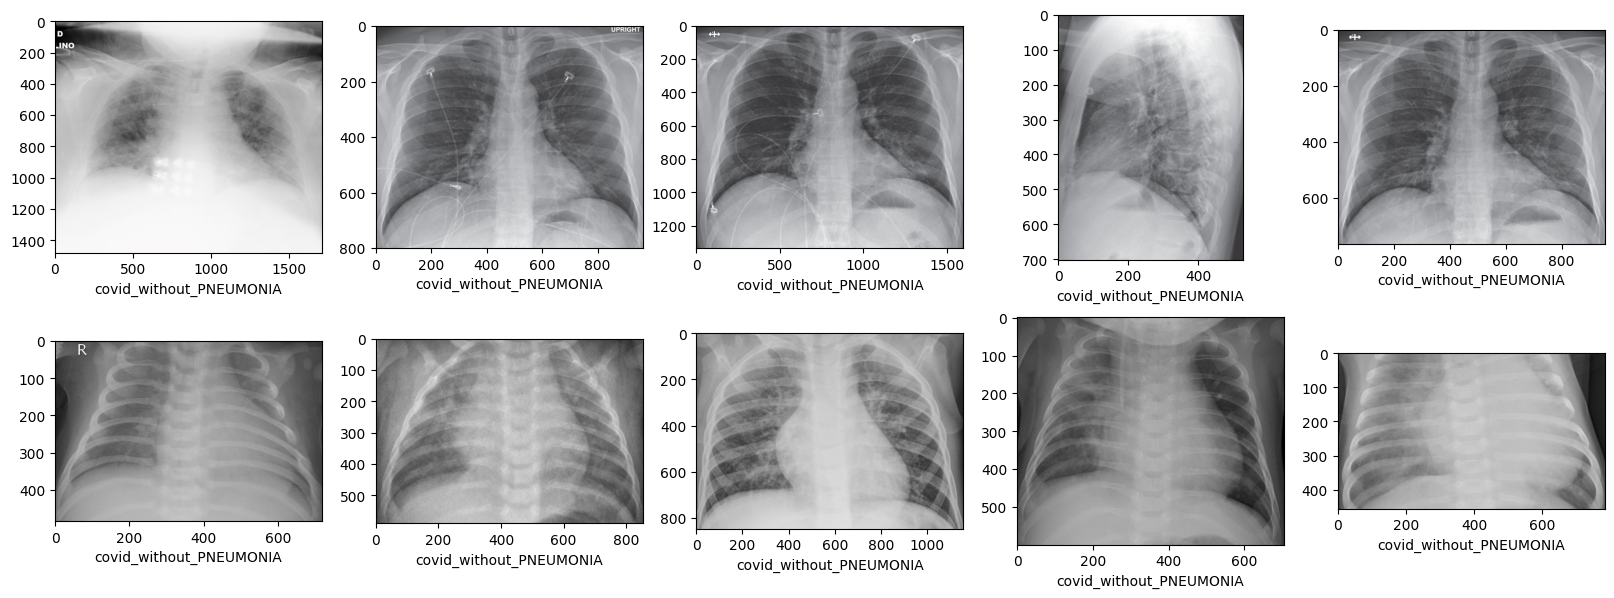

In [53]:
plt.figure(figsize=(20, 7))

for i, data_ in enumerate(iterable=data[:10]):
    path: str = data_["img_path"]
    label: str = data_["label"]
    plt.subplot(2, 5, i + 1)
    img: NDArray[uint] = imread(fname=path)
    plt.imshow(X=img)
    plt.xlabel(xlabel=label)

plt.show()

In [54]:
def rotate(image, angle: int = 90, scale: float = 1.0) -> NDArray:
    # Get the dimensions of the image
    h: int = image.shape[:2][0]
    w: int = image.shape[:2][1]
    # Compute the center of the image
    center: tuple[float, float] = (w / 2.0, h / 2.0)
    # Perform the rotation
    M: NDArray = getRotationMatrix2D(center=center, angle=angle, scale=scale)
    rotated: NDArray = warpAffine(src=image, M=M, dsize=(w, h))
    return rotated

In [55]:
images_array: list[NDArray] = []
images_label: list[str] = []
IMG_SIZE: tuple[Literal[100], Literal[100]] = (100, 100)

In [56]:
%time

for data_ in data:
    category: int = label2category[data_["label"]]
    img: NDArray = imread(fname=data_["img_path"])
    if category == 0:
        random_angle: int = np.random.choice(a=[90, 180, 270])
        random_flip: int = np.random.choice(a=[-1, 0, 1])
        for i in range(2):
            img: NDArray = rotate(image=img, angle=random_angle)
            # Flip the image horizontally, vertically, or both
            # flip_code = 0: flip vertically
            # flip_code > 0: flip horizontally
            # flip_code < 0: flip vertically and horizontally
            img: NDArray = flip(src=img, flipCode=random_flip)
            img: NDArray = resize(src=img, dsize=IMG_SIZE)
            images_array.append(img)
            images_label.append(data_["label"])
    else:
        img: NDArray = resize(src=img, dsize=IMG_SIZE)
        images_array.append(img)
        images_label.append(data_["label"])

CPU times: total: 0 ns
Wall time: 0 ns


Classes: ['covid_with_PNEUMONIA' 'covid_without_PNEUMONIA']
Counts: [289 286]


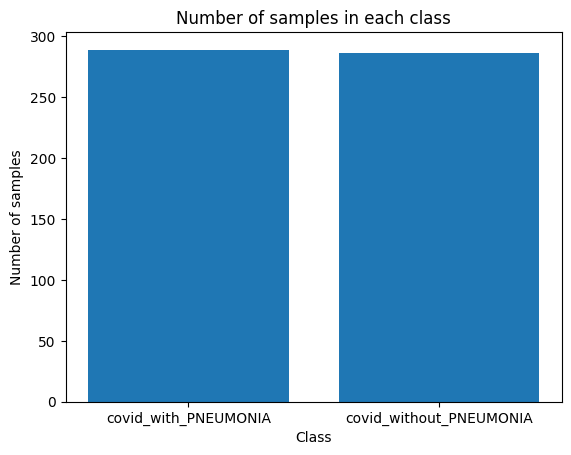

In [ ]:
# plot number of samples in each class

# Assuming 'data' is your numpy array with class labels
unique_elements = np.unique(ar=images_label, return_counts=True)
classes = unique_elements[0]
counts = unique_elements[1]

print(f"Classes: {classes}")
print(f"Counts: {counts}")

# Plotting the bar graph
plt.bar(x=classes, height=counts)
plt.xlabel(xlabel="Class")
plt.ylabel(ylabel="Number of samples")
plt.title(label="Number of samples in each class")
plt.show()

In [ ]:
images_array = np.array(images_array)
images_label = np.array(images_label)

print("shape of images array: {}".format(images_array.shape))
print("shape of images label: {}".format(images_label.shape))

In [ ]:
plt.figure(figsize=(20, 7))

for i, data_ in enumerate(images_array[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(data_)
    plt.xlabel(images_label[i])

plt.show()

In [ ]:
images_label = np.where(images_label == "covid_without_PNEUMONIA", 0, 1)

# Feature Extraction


In [ ]:
def calculate_centroid(block):
    """Calculate the centroid of a 3D matrix"""
    rows, cols, dep = block.shape
    x_centroid = 0.0
    y_centroid = 0.0
    z_centroid = 0.0
    for i in range(rows):
        for j in range(cols):
            for k in range(dep):
                x_centroid += i * block[i, j, k]
                y_centroid += j * block[i, j, k]
                z_centroid += k * block[i, j, k]
    total = np.sum(block)
    x_centroid = x_centroid / total
    y_centroid = y_centroid / total
    z_centroid = z_centroid / total
    return x_centroid, y_centroid, z_centroid

In [ ]:
def extract_features_with_centroid(image, block_size=50):
    features = np.zeros((100 // block_size, 100 // block_size, 3))
    for i in range(0, 100, block_size):
        for j in range(0, 100, block_size):
            block = image[i : i + block_size, j : j + block_size]
            x_centroid, y_centroid, z_centroid = calculate_centroid(block)
            features[int(i / block_size), int(j / block_size), 0] = x_centroid
            features[int(i / block_size), int(j / block_size), 1] = y_centroid
            features[int(i / block_size), int(j / block_size), 2] = z_centroid
    return features

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    images_array, images_label, test_size=0.3, random_state=42
)

In [ ]:
print(f"train input shape: {x_train.shape}")
print(f"train output shape: {y_train.shape}")
print(f"test input shape: {x_test.shape}")
print(f"test output shape: {y_test.shape}")

In [ ]:
%time

train_features_with_centroid = np.nan_to_num(
    np.array([extract_features_with_centroid(image) for image in x_train])
)

test_features_with_centroid = np.nan_to_num(
    np.array([extract_features_with_centroid(image) for image in x_test])
)

In [ ]:
train_features_with_centroid.shape, test_features_with_centroid.shape

In [ ]:
train_features_with_centroid = train_features_with_centroid.reshape(
    train_features_with_centroid.shape[0], -1
)

test_features_with_centroid = test_features_with_centroid.reshape(
    test_features_with_centroid.shape[0], -1
)

In [ ]:
train_features_with_centroid.shape

# Model


In [ ]:
class LogisticRegression:
    def __init__(
        self,
        lr=0.01,
        num_iter=1000,
        verbose=False,
    ):
        self.lr = lr
        self.num_iter = num_iter
        self.verbose = verbose
        self.weights = None
        self.bias = None
        self.x = None
        self.y = None
        self.classes_ = None
        self.m = None
        self.n = None
        self.losses = []
        self.accuracies = []

    def gradient_descent(self):
        y_hat = self.predict(self.x)
        dw = (1 / self.m) * np.dot(self.x.T, (y_hat - self.y))
        db = (1 / self.m) * np.sum(y_hat - self.y)
        self.weights -= self.lr * dw
        self.bias -= self.lr * db

    def predict(self, x):
        z = np.dot(x, self.weights) + self.bias
        predication = 1.0 / (1.0 + np.exp(-z))
        return predication

    def plot(self):
        plt.plot(self.losses)
        plt.plot(self.accuracies)
        plt.xlabel("Number of iterations")
        plt.ylabel("Loss")
        plt.legend(["Loss", "Accuracy"])
        plt.show()

    def loss(self):
        y_hat = self.predict(self.x)
        self.losses.append(
            -np.mean(
                self.y * np.log(y_hat + sys.float_info.min)
                + (1 - self.y) * np.log(1 - y_hat + sys.float_info.min)
            )
        )
        return self.losses[-1]

    def accuracy(self):
        y_hat = self.predict(self.x)
        acc = np.mean(y_hat.round() == self.y)
        self.accuracies.append(acc)

    def F1_score(self):
        y_hat = self.predict(self.x)
        return f1_score(self.y, y_hat.round())

    def precision(self):
        y_hat = self.predict(self.x)
        return precision_score(self.y, y_hat.round())

    def recall(self):
        y_hat = self.predict(self.x)
        return recall_score(self.y, y_hat.round())

    def fit(self, x, y):
        self.x = x
        self.y = y
        best_loss = sys.float_info.max
        patience = 5
        self.m, self.n = x.shape
        self.weights = np.random.rand(self.n)
        self.bias = np.random.rand()
        for _ in range(self.num_iter):
            self.gradient_descent()
            self.loss()
            self.accuracy()

            if self.losses[-1] < best_loss:
                best_loss = self.losses[-1]
                patience = 5
            else:
                patience -= 1
                if patience == 0:
                    break

        if self.verbose:
            print(f"\nFinal Loss: {self.losses[-1]}")
            print(f"Final Accuracy: {self.accuracies[-1]}")

    def eval(self, x, y):
        self.x = x
        self.y = y
        self.accuracy()
        if self.verbose:
            print(f"Accuracy: {self.accuracies[-1]}")
            print(f"F1 Score: {self.F1_score()}")
            print(f"Precision: {self.precision()}")
            print(f"Recall: {self.recall()}")

In [ ]:
model = LogisticRegression(verbose=True)

In [ ]:
np.unique(y_train), np.unique(y_test)

In [ ]:
train_features_with_centroid = (
    train_features_with_centroid - train_features_with_centroid.mean()
) / train_features_with_centroid.std()


test_features_with_centroid = (
    test_features_with_centroid - test_features_with_centroid.mean()
) / test_features_with_centroid.std()

In [ ]:
model.fit(train_features_with_centroid, y_train)

In [ ]:
model.plot()

In [ ]:
model.eval(train_features_with_centroid, y_train)

In [ ]:
model.eval(test_features_with_centroid, y_test)

In [ ]:
print(classification_report(y_test, model.predict(test_features_with_centroid).round()))

In [ ]:
x_train.shape[1]

In [ ]:
y_train.shape

# Particle Swarm Optimization


In [ ]:
tries = []

In [ ]:
class Particle:
    def __init__(self, bounds):
        self.position = np.array([np.random.uniform(b[0], b[1]) for b in bounds])
        self.velocity = np.array(
            [np.random.uniform(-abs(b[1] - b[0]), abs(b[1] - b[0])) for b in bounds]
        )
        self.best_position = self.position.copy()
        self.best_fitness = float("inf")
        self.fitness = float("inf")


def update_velocity(particle, global_best_position, w=0.5, c1=1.0, c2=2.0):
    inertia = w * particle.velocity
    cognitive = c1 * np.random.random() * (particle.best_position - particle.position)
    social = c2 * np.random.random() * (global_best_position - particle.position)
    particle.velocity = inertia + cognitive + social


def update_position(particle, bounds):
    particle.position += particle.velocity
    # Ensure the particle's position is within the bounds
    for i in range(len(bounds)):
        if particle.position[i] < bounds[i][0]:
            particle.position[i] = bounds[i][0]
        elif particle.position[i] > bounds[i][1]:
            particle.position[i] = bounds[i][1]


def objective_function(subset):
    tries.append(subset)
    print(f"\tTrying Subset: {round(subset[0])}, LR: {subset[1]}")
    X_train_subset = train_features_with_centroid[:, : round(subset[0])]
    X_test_subset = test_features_with_centroid[:, : round(subset[0])]
    model = LogisticRegression(lr=subset[1])
    model.fit(X_train_subset, y_train)
    model.eval(X_test_subset, y_test)
    return -model.F1_score()


def pso(objective_function, bounds, num_particles, max_iter):
    swarm = [Particle(bounds) for _ in range(num_particles)]
    global_best_position = np.zeros(len(bounds))
    global_best_fitness = float("inf")
    for iteration in range(max_iter):
        for particle in swarm:
            particle.fitness = objective_function(particle.position)
            if particle.fitness < particle.best_fitness:
                particle.best_fitness = particle.fitness
                particle.best_position = particle.position.copy()
            if particle.fitness < global_best_fitness:
                global_best_fitness = particle.fitness
                global_best_position = particle.position.copy()
        for particle in swarm:
            update_velocity(particle, global_best_position)
            update_position(particle, bounds)
        print(
            f"Iteration {iteration + 1}/{max_iter}, Global Best Fitness: {-global_best_fitness}, Global Best Position: {global_best_position}"
        )
    return global_best_position, -global_best_fitness

In [ ]:
best_position, best_fitness = pso(
    objective_function, bounds=[(2, 12), (0.01, 0.99)], num_particles=100, max_iter=100
)

In [ ]:
print(f"Best Position: {best_position}, Best Fitness: {best_fitness}")

In [ ]:
tries = np.array(tries)

In [ ]:
tries[:, 0] = np.round(tries[:, 0])
subsets = np.unique(tries[:, 0])
lrs = np.unique(tries[:, 1])

In [ ]:
subsets, lrs

# After Particle Swarm Optimization


In [ ]:
model = LogisticRegression(verbose=True, lr=best_position[1])

In [ ]:
model.fit(train_features_with_centroid[:, : round(best_position[0])], y_train)

In [ ]:
model.plot()

In [ ]:
model.eval(train_features_with_centroid[:, : round(best_position[0])], y_train)

In [ ]:
model.eval(test_features_with_centroid[:, : round(best_position[0])], y_test)

In [ ]:
print(
    classification_report(
        y_test,
        model.predict(
            test_features_with_centroid[:, : round(best_position[0])]
        ).round(),
    )
)

# Feature Reduction


In [ ]:
class LDA:
    def __init__(self):
        self.w = None

    def fit(self, X, y):
        m0 = np.mean(X[y == 0], axis=0)
        m1 = np.mean(X[y == 1], axis=0)
        S0 = np.dot((X[y == 0] - m0).T, (X[y == 0] - m0))
        S1 = np.dot((X[y == 1] - m1).T, (X[y == 1] - m1))
        Sw = S0 + S1
        self.w = np.dot(np.linalg.inv(Sw), (m1 - m0))

    def transform(self, X):
        result = np.dot(X, self.w)
        return (result - result.mean()) / result.std()

In [ ]:
lda = LDA()

In [ ]:
lda.fit(train_features_with_centroid[:, : round(best_position[0])], y_train)

In [ ]:
train_features_with_centroid = lda.transform(
    train_features_with_centroid[:, : round(best_position[0])]
)
test_features_with_centroid = lda.transform(
    test_features_with_centroid[:, : round(best_position[0])]
)


In [ ]:
train_features_with_centroid = train_features_with_centroid.reshape(-1, 1)
test_features_with_centroid = test_features_with_centroid.reshape(-1, 1)

In [ ]:
train_features_with_centroid.shape, test_features_with_centroid.shape

# After Feature Reduction

In [ ]:
model = LogisticRegression(verbose=True, lr=best_position[1])

In [ ]:
model.fit(train_features_with_centroid, y_train)

In [ ]:
model.plot()

In [ ]:
model.eval(train_features_with_centroid, y_train)

In [ ]:
model.eval(test_features_with_centroid, y_test)

In [ ]:
print(classification_report(y_test, model.predict(test_features_with_centroid).round()))